# Test Method

In [43]:
# Song Liu (song.liu@bristol.ac.uk), 01-06-2023
# All rights reserved.

# load csv files from archive folder
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm 


# Rergulariser to 
class GenReg(ABC, nn.Module): 
    def __init__(self, loss = nn.HuberLoss(), regtype:str='fp'):
        super().__init__()
        self.loss = loss    
        if regtype == 'fp':
            self.test_labs = [0]
        elif regtype == 'tp':
            self.test_labs = [1]
        elif regtype == 'both':
            self.test_labs = [0, 1]
        else:
            raise ValueError('type should be one of fp, tp, both')
        self.regtype = regtype.lower()
    
    @abstractmethod
    def subgroup_reg(self, scores_1:Tensor, scores_2:Tensor):
        pass
    
    def forward(self, labels, scores, group_data):
        groups = torch.unique(group_data)
        loss = 0
        # Iterate over true label types
        for test_label in self.test_labs:
            # Iterate over protected groups
            for group in groups:
                label_score = scores[labels==test_label]
                labelgroup_score = scores[(group_data==group) & (labels==test_label)]
                loss += self.subgroup_reg(labelgroup_score, label_score, test_label)
        return loss


class KDEReg(GenReg):
    a = 0.4920
    b = 0.2887
    c = 1.1893
    
    @staticmethod
    def F_est(y: Tensor)->Tensor:
        return torch.exp(-KDEReg.a*y**2 - KDEReg.b*y - KDEReg.c)
    
    def __init__(self, tau:int, h:int,logits=False, loss = nn.HuberLoss(), regtype:str='fp'):

        super().__init__(loss, regtype)
        self.tau = tau
        self.h = h
        self.logits=logits
    
    def subgroup_reg(self, scores_1:Tensor, scores_2:Tensor, test_label: int):
        # Cast onto [0,1] if necessary
        if self.logits:
            scores_1 = torch.sigmoid(scores_1)
            scores_2 = torch.sigmoid(scores_2)
        # Caclaulte kernel CDF estimates
        kernel_1 = torch.mean(self.F_est((self.tau-scores_1)/self.h)) - torch.mean(self.F_est((self.tau-scores_1)/self.h))
        kernel_2 = torch.mean(self.F_est((self.tau-scores_2)/self.h)) - torch.mean(self.F_est((self.tau-scores_2)/self.h))
        return self.loss(kernel_1, kernel_2)
    
class BCEReg(GenReg):
    def __init__(self, logit=False, loss = nn.HuberLoss(), regtype:str='fp'):
        super().__init__(loss, regtype)
        if logit:
            self.regloss = F.binary_cross_entropy_with_logits
        else:
            self.regloss = F.binary_cross_entropy
    def subgroup_reg(self, scores_1: Tensor, scores_2: Tensor, test_label:int):
        bce_1 = self.regloss(scores_1, torch.ones_like(scores_1)*test_label)
        bce_2 = self.regloss(scores_2, torch.ones_like(scores_2)*test_label)
        return self.loss(bce_1, bce_2)
    
def equality_loss(labels, preds, group_data, regtype: str =  "fp"):
    groups = torch.unique(group_data)
    if regtype == 'fp':
        test_labs = [0]
    elif regtype == 'tp':
        test_labs = [1]
    elif regtype == 'both':
        test_labs = [0, 1]
     
    loss = 0
    # Iterate over true label types
    for test_label in test_labs:
        # Iterate over protected groups
        for group in groups:
            label_preds = preds[labels==test_label]
            grouplabel_preds = preds[(group_data==group) & (labels==test_label)]
            loss += torch.abs(torch.mean(grouplabel_preds)-torch.mean(label_preds))
        return loss


class PWKDEReg(KDEReg): 
    # Re-define forward method to account for already separated scores  
    def forward(self, scores0, scores1, group_data0, group_data1):
        # Get data groups
        groups = torch.unique(torch.cat((group_data0, group_data1)))
        # Combine scores
        scores = {"0": scores0, "1": scores1}
        group_data = {"0": group_data0, "1": group_data1} 
        loss = 0
        # Iterate over true label types
        for test_label in self.test_labs:
            label_key = str(test_label)
            # Iterate over protected groups
            for group in groups:
                label_score = scores[label_key]
                labelgroup_score = scores[label_key][group_data[label_key]==group]
                loss += self.subgroup_reg(labelgroup_score, label_score, test_label)
        return loss


class PWBCEReg(BCEReg): 
    # Re-define forward method to account for already separated scores  
    def forward(self, scores0, scores1, group_data0, group_data1):
        return PWKDEReg.forward(self, scores0, scores1, group_data0, group_data1)

ROC space is $[0,1]^2$, where the x axis is False Positive Rate (FPR) and y axis is True Positive Rate (TPR).

Recall, $\mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$ and $\mathrm{FPR} = \frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}}$.

In [5]:
base = pd.read_csv('../../archive/Variant I.csv')
# For now filter to only get CA and CB employment_status values
# This is for simplicity and to be removed later.
base = base[base['employment_status'].isin(['CA', 'CB'])]
# remove 'income', 'customer_age', 'employment_status' columns as they are protected
sensitive = base[['income', 'customer_age', 'employment_status']]
employment_status = base['employment_status'].astype("category").cat.codes
base = base.drop(columns=['income', 'customer_age', 'employment_status'])
# convert categorical variables in 'payment_type' to integers
base['payment_type'] = base['payment_type'].astype('category')
base['housing_status'] = base['housing_status'].astype('category')
base['source'] = base['source'].astype('category')
base['device_os'] = base['device_os'].astype('category')

cat_columns = base.select_dtypes(['category']).columns
base[cat_columns] = base[cat_columns].apply(lambda x: x.cat.codes)
base_torch = torch.tensor(base.to_numpy()).float()

X = base_torch[:,1:]
y = base_torch[:,0]
group = torch.tensor(employment_status.to_numpy()).float()

# class prior 
prior = torch.mean(y)

print('class prior for positive:', prior)
print('class prior for negative:', 1-prior)


X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(X, y, group, test_size=0.1, random_state=0)

class prior for positive: tensor(0.0118)
class prior for negative: tensor(0.9882)


In [33]:
def TPR(pred, label):
    TP = torch.sum((pred==1) & (label==1))
    FN = torch.sum((pred==0) & (label==1))
    return TP/(TP+FN)

def FPR(pred, label):
    FP = torch.sum((pred==1) & (label==0))
    TN = torch.sum((pred==0) & (label==0))
    return FP/(FP+TN)

def roc(pred, label, scores_probs=False):
    # If score are probabilities, we need to convert them to scores
    if scores_probs:
        pred = torch.log(pred/(1-pred))
    fpr, tpr = [], []
    tmax = max(pred)
    tmin = min(pred)
    for t in torch.linspace(tmin, tmax, 100):
        p = pred > t
        tpr.append(TPR(p, label))
        fpr.append(FPR(p, label))
    return fpr, tpr

def AUC(fpr, tpr):
    return sum([(tpr[i]+tpr[i-1])*(fpr[i-1]-fpr[i])/2 for i in range(1, len(fpr))])    

def aucloss(pred, label):
    if pred[label==1].shape[0] == 0: # you might end up with no positive samples
        print('no positive samples!')
    pos_pred = pred[label==1]
    neg_pred = pred[label==0]
    
    # hinge loss
    T = (neg_pred.T - pos_pred)
    loss = torch.max(T, torch.zeros_like(T))/2
    loss = torch.mean(loss, dim = 0)
    loss = torch.mean(loss)
    return loss

def paired_aucloss(scores0: Tensor, scores1: Tensor):
    """Calculate the auc loss for identical length tensor of class 0 scores and class 1 scores

    Args:
        scores0 (Tensor): Scores of x values from class 0 data
        scores1 (Tensor): Scores of x values from class 1 data

    Returns:
        Tensor: AUC loss 
    """
    loss = F.relu(scores0 - scores1)
    loss = torch.mean(loss)
    return loss

Do initial run of model. We will start with logitistic regression and $\tau=0.5$.

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_214366/565519512.py:14: RuntimeWarning: divide by zero encountered in log
  pred = np.log(pred/(1-pred))
/home/cn21903/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:134: RuntimeWarning: invalid value encountered in double_scalars
  delta = stop - start
 20%|██        | 1/5 [00:10<00:43, 10.81s/it]

1.090000033378601


 40%|████      | 2/5 [00:21<00:32, 10.96s/it]

1.2000000476837158


 60%|██████    | 3/5 [00:33<00:22, 11.12s/it]

1.25


 80%|████████  | 4/5 [00:43<00:10, 11.00s/it]

1.159999966621399


100%|██████████| 5/5 [00:55<00:00, 11.05s/it]

1.1200000047683716


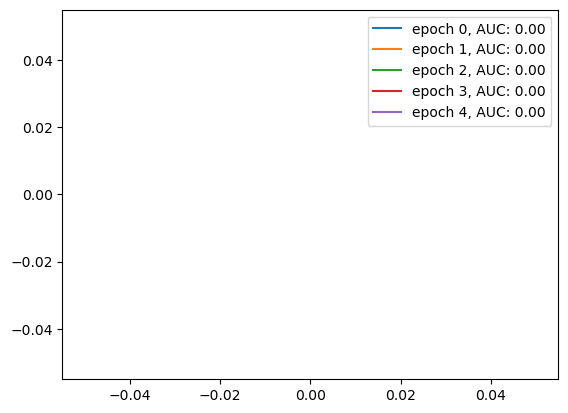

In [10]:
# Set up data
data = TensorDataset(
    X_train,
    y_train,
    group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
model = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid())
lossfunc = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
regularise = KDEReg(0.5, 0.01, regtype='fp')


fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss += 0*regularise(y, scores, group)
        loss.backward()
        optimizer.step()
    print(loss.item())
    pred_te = model(X_test).detach()[:,0]
    fpr, tpr = roc(pred_te, y_test, scores_probs=True)
    auc = AUC(fpr, tpr)
    ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
    
ax.legend()
plt.show()


Have score as linear then take logits in loss. This should make AUC calculation better. Now also check the 

  0%|          | 0/5 [00:00<?, ?it/s]

Loss:  5.032
Equality Error:  0.000


 20%|██        | 1/5 [00:14<00:58, 14.56s/it]

Loss:  5.039
Equality Error:  0.000


 40%|████      | 2/5 [00:29<00:43, 14.57s/it]

Loss:  0.121
Equality Error:  0.000


 60%|██████    | 3/5 [00:40<00:26, 13.14s/it]

Loss:  0.067
Equality Error:  0.000


 80%|████████  | 4/5 [00:51<00:12, 12.35s/it]

Loss:  0.055
Equality Error:  0.000


100%|██████████| 5/5 [01:04<00:00, 12.94s/it]


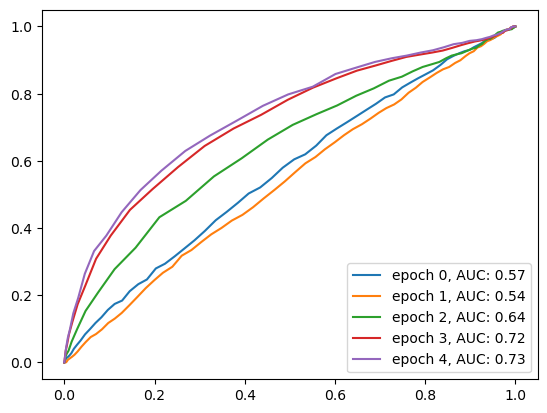

In [52]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
model = nn.Linear(d, 1)
lossfunc = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
tau = 0.5
regularise = KDEReg(tau, 0.01, regtype='fp', logits=True)


fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss += regularise(y, scores, group)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Loss: {loss.item(): 4.3f}")
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = (torch.sigmoid(scores_te)>tau).float()
        # Get Odd loss 
        print(f"Equality Error: {equality_loss(y_test, pred_te, group_test, regtype='fp').item(): 4.3f}")
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
ax.legend()
plt.show()


## Test different $\tau$ where close FPR is less easy

  0%|          | 0/5 [00:00<?, ?it/s]

Loss:  2.152
Equality Error:  0.003


 20%|██        | 1/5 [00:12<00:49, 12.43s/it]

Loss:  5.432
Equality Error:  0.000


 40%|████      | 2/5 [00:27<00:42, 14.07s/it]

Loss:  0.205
Equality Error:  0.000


 60%|██████    | 3/5 [00:40<00:27, 13.63s/it]

Loss:  0.087
Equality Error:  0.031


 80%|████████  | 4/5 [00:52<00:12, 12.97s/it]

Loss:  0.085
Equality Error:  0.024


100%|██████████| 5/5 [01:07<00:00, 13.50s/it]


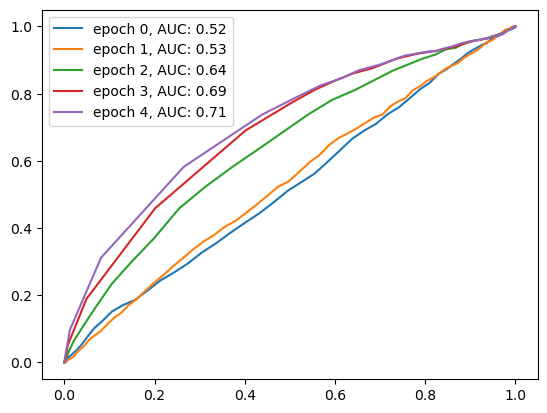

In [60]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
model = nn.Linear(d, 1)
lossfunc = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
tau = 0.01
regularise = KDEReg(tau, 0.01, regtype='fp', logits=True)


fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        # loss += regularise(y, scores, group)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Loss: {loss.item(): 4.3f}")
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = (torch.sigmoid(scores_te)>tau).float()
        # Get Odd loss 
        print(f"Equality Error: {equality_loss(y_test, pred_te, group_test, regtype='fp').item(): 4.3f}")
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
ax.legend()
plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss:  4.682
Equality Error:  0.001


 20%|██        | 1/5 [00:13<00:53, 13.34s/it]

Loss:  2.035
Equality Error:  0.000


 40%|████      | 2/5 [00:25<00:38, 12.83s/it]

Loss:  1.691
Equality Error:  0.000


 60%|██████    | 3/5 [00:39<00:26, 13.08s/it]

Loss:  1.535
Equality Error:  0.001


 80%|████████  | 4/5 [00:51<00:12, 12.70s/it]

Loss:  1.432
Equality Error:  0.001


100%|██████████| 5/5 [01:03<00:00, 12.77s/it]


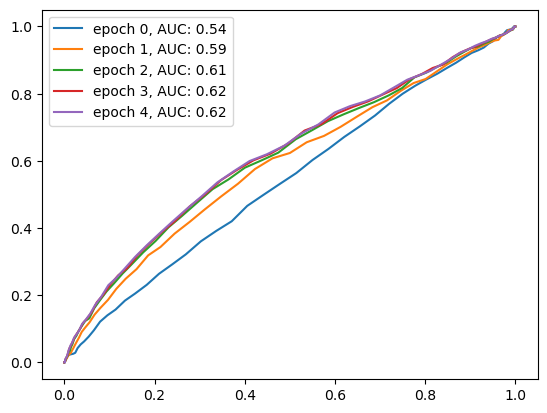

In [61]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
model = nn.Linear(d, 1)
lossfunc = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
tau = 0.01
regularise = KDEReg(tau, 0.01, regtype='fp', logits=True)


fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss += regularise(y, scores, group)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Loss: {loss.item(): 4.3f}")
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = (torch.sigmoid(scores_te)>tau).float()
        # Get Odd loss 
        print(f"Equality Error: {equality_loss(y_test, pred_te, group_test, regtype='fp').item(): 4.3f}")
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
ax.legend()
plt.show()


The regularisation does seem to help reduce the bias. We now try  performing this repeatedly at multiple levels.

100%|██████████| 5/5 [00:51<00:00, 10.38s/it]


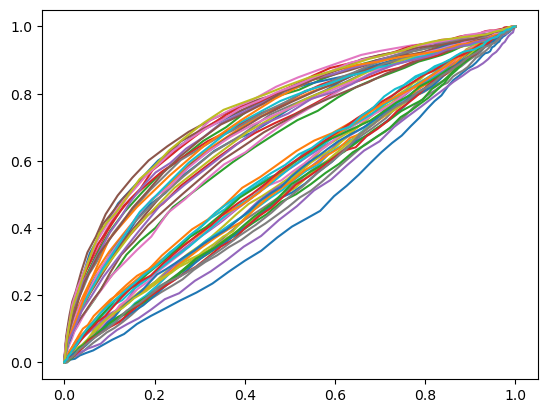

In [13]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCEWithLogitsLoss()
model = nn.Linear(d, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
tau = 0.01
regularise = KDEReg(tau, 0.01, regtype='fp', logits=True)


fig,ax = plt.subplots()
equal_losses = []
aucs = []
rocs = []
lambs = [0.,0.25,0.5,0.75,1.]
for lamb in lambs:
    equal_losses.append([])
    aucs.append([])
    rocs.append([])
    for j in range(10):
        # Set-up model
        model = nn.Linear(d, 1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
        # Train model
        for epoch in tqdm(range(5)):
            for x, y, group in dataloader:
                optimizer.zero_grad()
                scores = model(x).squeeze()
                loss = lossfunc(scores, y)
                loss += lamb*regularise(y, scores, group)
                loss.backward()
                optimizer.step()
            scheduler.step()
            
        # with torch.no_grad():
        #     scores_te = model(X_test).squeeze()
        #     pred_te = (torch.sigmoid(scores_te)>tau).float()
        #     # Get Odd loss 
        #     equal_loss = equality_loss(y_test, pred_te, group_test, regtype='fp').item()
        #     equal_losses[-1].append(equal_loss)
            
        #     fpr, tpr = roc(scores_te, y_test)
        #     rocs[-1].append([fpr, tpr])
        #     auc = AUC(fpr, tpr)
        #     aucs[-1].append(auc)
        #     ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))

# dim 0: lambda, dim 1: run
equal_losses = torch.tensor(equal_losses)
aucs = torch.tensor(aucs)
# dim 2: fpr or tpr dim 3: value 
rocs = torch.tensor(rocs)

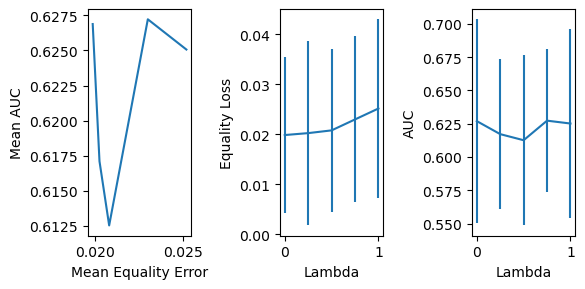

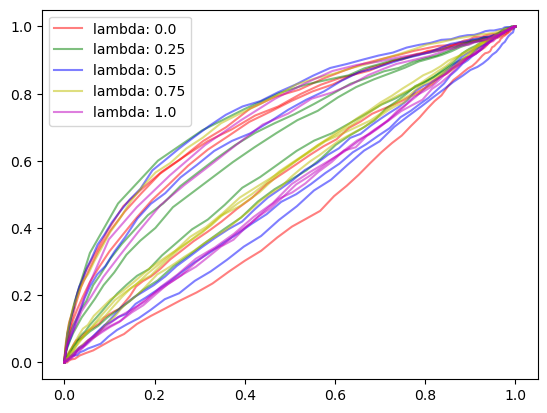

In [31]:

fig, ax = plt.subplots(ncols=3, figsize=(6,3))
ax[0].plot(torch.mean(equal_losses,dim=1), torch.mean(aucs, dim=1))
ax[0].set_xlabel('Mean Equality Error')
ax[0].set_ylabel('Mean AUC')
ax[1].errorbar(lambs, torch.mean(equal_losses, dim=1), yerr=1.96*torch.std(equal_losses, dim=1)/10**0.5, label = 'Mean Equal Loss')
ax[1].set_xlabel('Lambda')
ax[1].set_ylabel('Equality Loss')
ax[2].errorbar(lambs, torch.mean(aucs, dim=1), yerr=1.96*torch.std(aucs, dim=1)/10**0.5, label = 'Mean AUC')
ax[2].set_xlabel('Lambda')
ax[2].set_ylabel('AUC')
fig.tight_layout()

colours = ['r', 'g', 'b', 'y', 'm']
fig, ax = plt.subplots()
for i,lamb in enumerate(lambs):
    for j in range(aucs.shape[0]):
        if j == 0:
            ax.plot(rocs[i,j,0], rocs[i,j,1], label = f'lambda: {lamb}', color=colours[i], alpha=0.5)
        else:
            ax.plot(rocs[i,j,0], rocs[i,j,1],alpha=0.5, color=colours[i])
ax.legend()


# To do - AUC Loss
Try with paired AUC as loss

In [44]:
a=0
str(a)

'0'

  0%|          | 0/100 [00:00<?, ?it/s]

68.03404235839844


  1%|          | 1/100 [00:01<02:11,  1.33s/it]

31.06386375427246


  2%|▏         | 2/100 [00:02<02:10,  1.33s/it]

18.495140075683594


  3%|▎         | 3/100 [00:03<01:59,  1.23s/it]

14.790634155273438


  4%|▍         | 4/100 [00:04<01:52,  1.18s/it]

5.729053497314453


  5%|▌         | 5/100 [00:06<01:51,  1.17s/it]

20.54029083251953


  6%|▌         | 6/100 [00:07<01:48,  1.15s/it]

7.733609199523926


  7%|▋         | 7/100 [00:08<01:45,  1.14s/it]

3.0073554515838623


  8%|▊         | 8/100 [00:09<01:43,  1.13s/it]

3.9481494426727295


  9%|▉         | 9/100 [00:10<01:41,  1.11s/it]

5.372673034667969


 10%|█         | 10/100 [00:11<01:50,  1.23s/it]

5.70945930480957


 11%|█         | 11/100 [00:12<01:45,  1.18s/it]

2.661658525466919


 12%|█▏        | 12/100 [00:14<01:42,  1.16s/it]

4.124579906463623


 13%|█▎        | 13/100 [00:15<01:37,  1.12s/it]

7.361201286315918


 14%|█▍        | 14/100 [00:16<01:42,  1.19s/it]

7.51866340637207


 15%|█▌        | 15/100 [00:17<01:41,  1.19s/it]

7.3150954246521


 16%|█▌        | 16/100 [00:18<01:42,  1.22s/it]

4.284146308898926


 17%|█▋        | 17/100 [00:20<01:42,  1.23s/it]

2.5406606197357178


 18%|█▊        | 18/100 [00:21<01:41,  1.24s/it]

4.499283313751221


 19%|█▉        | 19/100 [00:22<01:33,  1.15s/it]

7.6919121742248535


 20%|██        | 20/100 [00:23<01:32,  1.16s/it]

11.508088111877441


 21%|██        | 21/100 [00:24<01:28,  1.12s/it]

4.58103609085083


 22%|██▏       | 22/100 [00:25<01:26,  1.11s/it]

2.8256044387817383


 23%|██▎       | 23/100 [00:27<01:30,  1.17s/it]

11.317715644836426


 24%|██▍       | 24/100 [00:28<01:27,  1.14s/it]

4.911802768707275


 25%|██▌       | 25/100 [00:29<01:24,  1.13s/it]

6.319965362548828


 26%|██▌       | 26/100 [00:30<01:33,  1.27s/it]

14.911439895629883


 27%|██▋       | 27/100 [00:32<01:38,  1.35s/it]

7.566151142120361


 28%|██▊       | 28/100 [00:34<01:47,  1.50s/it]

16.6862850189209


 29%|██▉       | 29/100 [00:36<01:53,  1.60s/it]

4.9979658126831055


 30%|███       | 30/100 [00:37<01:51,  1.60s/it]

7.136168003082275


 31%|███       | 31/100 [00:39<01:47,  1.56s/it]

6.130817413330078


 32%|███▏      | 32/100 [00:40<01:44,  1.54s/it]

5.839023113250732


 33%|███▎      | 33/100 [00:42<01:45,  1.57s/it]

3.5625176429748535


 34%|███▍      | 34/100 [00:43<01:45,  1.60s/it]

5.310990333557129


 35%|███▌      | 35/100 [00:45<01:46,  1.64s/it]

3.6581997871398926


 36%|███▌      | 36/100 [00:47<01:40,  1.56s/it]

3.453484058380127


 37%|███▋      | 37/100 [00:48<01:38,  1.57s/it]

4.019313335418701


 38%|███▊      | 38/100 [00:50<01:34,  1.53s/it]

4.125887393951416


 39%|███▉      | 39/100 [00:51<01:29,  1.47s/it]

5.065290927886963


 40%|████      | 40/100 [00:52<01:29,  1.50s/it]

3.2953505516052246


 41%|████      | 41/100 [00:54<01:23,  1.42s/it]

3.552798271179199


 42%|████▏     | 42/100 [00:55<01:22,  1.43s/it]

4.8436360359191895


 43%|████▎     | 43/100 [00:56<01:18,  1.38s/it]

6.3604302406311035


 44%|████▍     | 44/100 [00:58<01:24,  1.51s/it]

4.599794864654541


 45%|████▌     | 45/100 [01:00<01:21,  1.48s/it]

4.3803534507751465


 46%|████▌     | 46/100 [01:01<01:15,  1.40s/it]

3.664273738861084


 47%|████▋     | 47/100 [01:02<01:13,  1.39s/it]

5.136061668395996


 48%|████▊     | 48/100 [01:03<01:07,  1.29s/it]

5.045942783355713


 49%|████▉     | 49/100 [01:04<01:02,  1.23s/it]

3.326087713241577


 50%|█████     | 50/100 [01:05<01:00,  1.21s/it]

3.625973701477051


 51%|█████     | 51/100 [01:06<00:56,  1.15s/it]

11.77446174621582


 52%|█████▏    | 52/100 [01:08<00:55,  1.15s/it]

10.176139831542969


 53%|█████▎    | 53/100 [01:09<00:53,  1.13s/it]

4.641598701477051


 54%|█████▍    | 54/100 [01:10<00:50,  1.10s/it]

6.581539154052734


 55%|█████▌    | 55/100 [01:11<00:47,  1.06s/it]

11.784991264343262


 56%|█████▌    | 56/100 [01:12<00:47,  1.09s/it]

5.369199275970459


 57%|█████▋    | 57/100 [01:13<00:49,  1.15s/it]

4.880800247192383


 58%|█████▊    | 58/100 [01:14<00:45,  1.09s/it]

2.9845011234283447


 59%|█████▉    | 59/100 [01:16<00:50,  1.24s/it]

4.006537914276123


 60%|██████    | 60/100 [01:17<00:48,  1.22s/it]

4.3555684089660645


 61%|██████    | 61/100 [01:18<00:47,  1.22s/it]

8.091436386108398


 62%|██████▏   | 62/100 [01:19<00:46,  1.23s/it]

2.6916959285736084


 63%|██████▎   | 63/100 [01:20<00:43,  1.18s/it]

3.7888033390045166


 64%|██████▍   | 64/100 [01:22<00:47,  1.31s/it]

6.98913049697876


 65%|██████▌   | 65/100 [01:23<00:44,  1.27s/it]

5.443192481994629


 66%|██████▌   | 66/100 [01:24<00:43,  1.27s/it]

4.568275451660156


 67%|██████▋   | 67/100 [01:25<00:39,  1.19s/it]

8.785250663757324


 68%|██████▊   | 68/100 [01:27<00:38,  1.21s/it]

8.645782470703125


 69%|██████▉   | 69/100 [01:28<00:37,  1.20s/it]

3.727978467941284


 70%|███████   | 70/100 [01:29<00:33,  1.13s/it]

12.933211326599121


 71%|███████   | 71/100 [01:30<00:33,  1.16s/it]

15.494951248168945


 72%|███████▏  | 72/100 [01:31<00:32,  1.14s/it]

9.315115928649902


 73%|███████▎  | 73/100 [01:32<00:30,  1.12s/it]

6.227048873901367


 74%|███████▍  | 74/100 [01:33<00:29,  1.13s/it]

5.022209167480469


 75%|███████▌  | 75/100 [01:34<00:26,  1.07s/it]

6.767429351806641


 76%|███████▌  | 76/100 [01:36<00:26,  1.09s/it]

3.8636274337768555


 77%|███████▋  | 77/100 [01:36<00:24,  1.06s/it]

6.651050567626953


 78%|███████▊  | 78/100 [01:38<00:26,  1.20s/it]

4.332283973693848


 79%|███████▉  | 79/100 [01:39<00:25,  1.21s/it]

4.070579528808594


 80%|████████  | 80/100 [01:40<00:23,  1.16s/it]

4.256807804107666


 81%|████████  | 81/100 [01:42<00:22,  1.20s/it]

5.121256351470947


 82%|████████▏ | 82/100 [01:43<00:24,  1.38s/it]

4.712662220001221


 83%|████████▎ | 83/100 [01:45<00:23,  1.39s/it]

3.35850191116333


 84%|████████▍ | 84/100 [01:46<00:21,  1.37s/it]

4.2814812660217285


 85%|████████▌ | 85/100 [01:48<00:20,  1.38s/it]

6.692761421203613


 86%|████████▌ | 86/100 [01:49<00:18,  1.29s/it]

8.045295715332031


 87%|████████▋ | 87/100 [01:50<00:15,  1.18s/it]

8.789613723754883


 88%|████████▊ | 88/100 [01:51<00:14,  1.21s/it]

9.494178771972656


 89%|████████▉ | 89/100 [01:52<00:12,  1.15s/it]

3.376101493835449


 90%|█████████ | 90/100 [01:53<00:11,  1.13s/it]

7.242541313171387


 91%|█████████ | 91/100 [01:54<00:10,  1.19s/it]

11.226527214050293


 92%|█████████▏| 92/100 [01:55<00:08,  1.12s/it]

5.428932189941406


 93%|█████████▎| 93/100 [01:57<00:08,  1.18s/it]

4.766255855560303


 94%|█████████▍| 94/100 [01:58<00:07,  1.18s/it]

5.427707672119141


 95%|█████████▌| 95/100 [01:59<00:05,  1.12s/it]

4.318256855010986


 96%|█████████▌| 96/100 [02:00<00:04,  1.11s/it]

4.200810432434082


 97%|█████████▋| 97/100 [02:01<00:03,  1.16s/it]

7.1663126945495605


 98%|█████████▊| 98/100 [02:02<00:02,  1.24s/it]

6.559001922607422


 99%|█████████▉| 99/100 [02:03<00:01,  1.18s/it]

3.591041326522827


100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


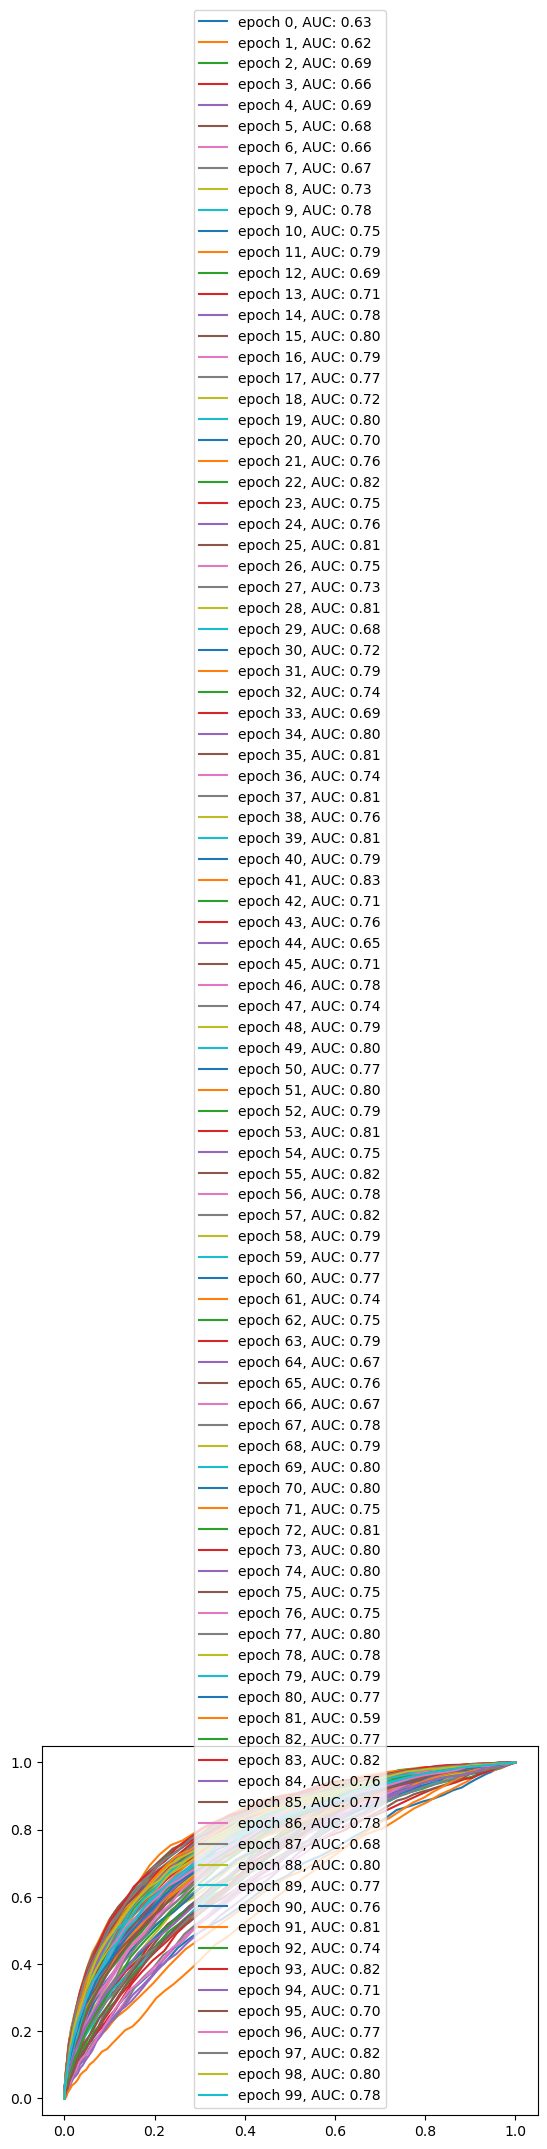

In [49]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
group_train0 = group_train[y_train==0]
group_train1 = group_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, group_train0)
data1 = TensorDataset(
    X_train1, group_train1) 
small_batch = 1000
batch_rep = 1
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)

# Set-up model
d = X_train.shape[1]
model = nn.Linear(d, 1)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
regularise = PWKDEReg(0.5, 0.01, regtype='fp', logits=True)


fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(100)):
    for (x0, group0), (x1, group1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
        loss = lossfunc(scores0, scores1)
        loss += regularise(scores0, scores1, group0, group1)
        loss.backward()
        optimizer.step()
    print(loss.item())
    pred_te = model(X_test).squeeze().detach()
    fpr, tpr = roc(pred_te, y_test)
    auc = AUC(fpr, tpr)
    ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
    
ax.legend()
plt.show()


# Further Questions:
* Do we work with fairness for just 1 $\tau$ value or across all (like auc)?
* Do we use a different closeness metric for fairness than absolute erro in the probabilties?
* For multiple groups, do we take all combinations or regularise each separately?